# Credit Card Dataset Exploration, Analysis and Prediction Tasks

### project in work

Dataset taken from: https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m

In [2]:
import torch
from dateutil import parser
import itertools
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import random
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from dython.nominal import associations

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

C:\Users\Nadine\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Description of data attributes

In [3]:
data=pd.read_csv('data/CreditCard/BankChurners.csv')
pd.set_option('display.max_columns', None)
data.head(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


### Set the Clientnum column containing client IDs as index and drop the two unnecessary columns containing Naive Bayes Classification Values
#### Setting the Clientnum as index also makes sure, that the dataset contains no entries with identical Clientnum value

In [4]:
data = data.set_index('CLIENTNUM')
data = data.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', axis='columns')
data = data.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', axis='columns')
data.head(2)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10127 entries, 768805383 to 714337233
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14 

#### No attribute contains missing values

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.0,0.759941,0.219207,0.0,0.631,0.736,0.859,3.397


In [7]:
data.describe(exclude=np.number).T

,count,unique,top,freq
Attrition_Flag,10127,2,Existing Customer,8500
Gender,10127,2,F,5358
Education_Level,10127,7,Graduate,3128
Marital_Status,10127,4,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436


#### Check for duplicate entries independently from the entry ids
no duplicate entries found

In [8]:
data[data.duplicated()]

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,,,


### Print all unique non-numerical values to check for case sensitivities, spelling mistakes etc
#### found no duplicates with spelling mistakes etc

In [9]:
for col in data.select_dtypes(exclude=np.number).columns:
    print(data[col].unique())


['Existing Customer' 'Attrited Customer']
['M' 'F']
['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
['Married' 'Single' 'Unknown' 'Divorced']
['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
['Blue' 'Gold' 'Silver' 'Platinum']


### Plot distribution of numerical attributes

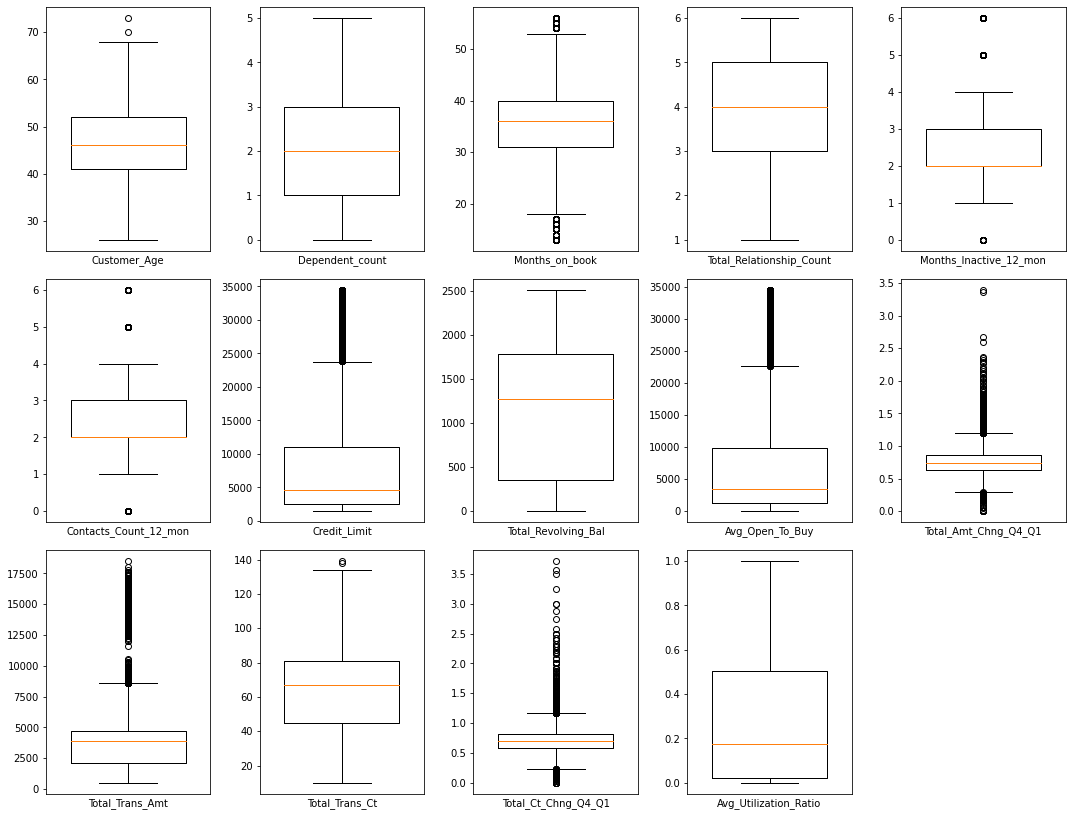

In [10]:
i=1
plt.figure(figsize=(15,15))
for attr in data.select_dtypes(include=np.number):
    plt.subplot(4,5,i)
    plt.boxplot(data[attr], widths=[0.7])
    plt.tight_layout()
    plt.xlabel(attr)
    plt.xticks([])
    i+=1


### Apply label encoding to attributes containing categorical values
Numerical labels for Education_Level and Income_Category are additionally placed in order with respect to the achieved level of education and to income height

In [11]:
data['Attrition_Flag'] = data['Attrition_Flag'].astype('category')
data['Attrition_Flag_ID'] = data['Attrition_Flag'].cat.codes

data['Gender'] = data['Gender'].astype('category')
data['Gender_ID'] = data['Gender'].cat.codes

data['Card_Category'] = data['Card_Category'].astype('category')
data['Card_Category_ID'] = data['Card_Category'].cat.codes

data['Marital_Status'] = data['Marital_Status'].astype('category')
data['Marital_Status_ID'] = data['Marital_Status'].cat.codes

education_order = ['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']
data['Education_Level'] = data['Education_Level'].astype('category')
data['Education_Level_ID'] = data['Education_Level'].apply(lambda x: education_order.index(x))
data['Education_Level_ID'] = data['Education_Level_ID'].astype('int')

income_order = ['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']
data['Income_Category'] = data['Income_Category'].astype('category')
data['Income_Category_ID'] = data['Income_Category'].apply(lambda x: income_order.index(x))
data['Income_Category_ID'] = data['Income_Category_ID'].astype('int')


# Education_Level : 'High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate' 'Doctorate'
# Income_Category : '$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +' 'Unknown'

data.head(2)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag_ID,Gender_ID,Card_Category_ID,Marital_Status_ID,Education_Level_ID,Income_Category_ID
CLIENTNUM,,,,,,,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1,1,0,1,2,3
818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1,0,0,2,4,1


### Apply Normalisation to numerical data

In [12]:
for column in data.select_dtypes(include=np.number):
    scaler = StandardScaler()
    data[[f'{column}_Scaled']] = scaler.fit_transform(data[[column]])

data.head(2)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag_ID,Gender_ID,Card_Category_ID,Marital_Status_ID,Education_Level_ID,Income_Category_ID,Customer_Age_Scaled,Dependent_count_Scaled,Months_on_book_Scaled,Total_Relationship_Count_Scaled,Months_Inactive_12_mon_Scaled,Contacts_Count_12_mon_Scaled,Credit_Limit_Scaled,Total_Revolving_Bal_Scaled,Avg_Open_To_Buy_Scaled,Total_Amt_Chng_Q4_Q1_Scaled,Total_Trans_Amt_Scaled,Total_Trans_Ct_Scaled,Total_Ct_Chng_Q4_Q1_Scaled,Avg_Utilization_Ratio_Scaled,Attrition_Flag_ID_Scaled,Gender_ID_Scaled,Card_Category_ID_Scaled,Marital_Status_ID_Scaled,Education_Level_ID_Scaled,Income_Category_ID_Scaled
CLIENTNUM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1,1,0,1,2,3,-0.165406,0.503368,0.384621,0.763943,-1.327136,0.492404,0.446622,-0.473422,0.488971,2.623494,-0.959707,-0.973895,3.834003,-0.775882,0.437506,1.059956,-0.259473,-0.628128,-0.354022,0.620039
818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1,0,0,2,4,1,0.333570,2.043199,1.010715,1.407306,-1.327136,-0.411616,-0.041367,-0.366667,-0.008486,3.563293,-0.916433,-1.357340,12.608573,-0.616276,0.437506,-0.943436,-0.259473,0.727306,0.822218,-0.736292


### Get a list of the transformed attributes' names

In [13]:
numerical_attributes = []
categ_attributes = []
scaled_features = []
for attr in data.select_dtypes(include=np.number):
    if not 'ID' in attr and not 'Scaled' in attr:
        numerical_attributes.append(attr)
    if 'ID'in attr and not 'ID_Scaled' in attr:
        categ_attributes.append(attr)
    if 'Scaled' in attr:
        scaled_features.append(attr)
        
numerical_attributes.append('Income_Category_ID')
numerical_attributes.append('Education_Level_ID')
print(f'Scaled features: {scaled_features}\n')
print(f'Categorical features: {categ_attributes}')

Scaled features: ['Customer_Age_Scaled', 'Dependent_count_Scaled', 'Months_on_book_Scaled', 'Total_Relationship_Count_Scaled', 'Months_Inactive_12_mon_Scaled', 'Contacts_Count_12_mon_Scaled', 'Credit_Limit_Scaled', 'Total_Revolving_Bal_Scaled', 'Avg_Open_To_Buy_Scaled', 'Total_Amt_Chng_Q4_Q1_Scaled', 'Total_Trans_Amt_Scaled', 'Total_Trans_Ct_Scaled', 'Total_Ct_Chng_Q4_Q1_Scaled', 'Avg_Utilization_Ratio_Scaled', 'Attrition_Flag_ID_Scaled', 'Gender_ID_Scaled', 'Card_Category_ID_Scaled', 'Marital_Status_ID_Scaled', 'Education_Level_ID_Scaled', 'Income_Category_ID_Scaled']

Categorical features: ['Attrition_Flag_ID', 'Gender_ID', 'Card_Category_ID', 'Marital_Status_ID', 'Education_Level_ID', 'Income_Category_ID']


### Plot distribution of categorical attributes

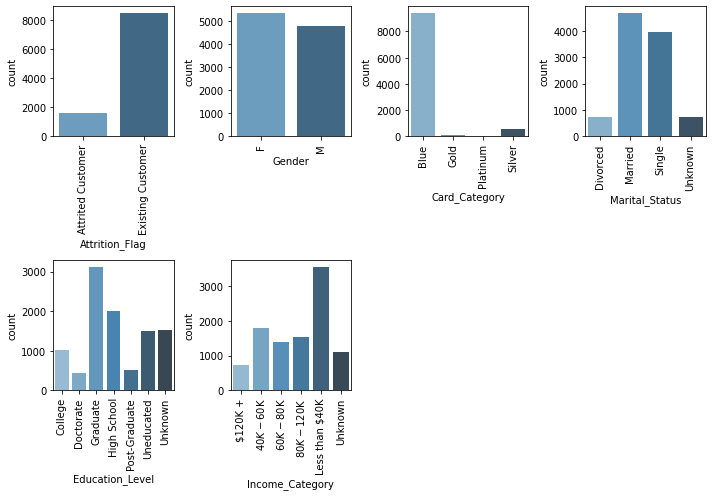

In [15]:
import re

i=1
plt.figure(figsize=(10,7))
for attr in categ_attributes:
    attr = re.sub('\_ID$', '', attr)
    plt.subplot(2,4,i)
    sns.countplot(x=data[attr], palette='Blues_d', hue=data[attr], legend=False)
    plt.tight_layout()
    plt.xlabel(attr)
    plt.xticks(rotation=90)
    plt.tight_layout()
    i+=1

- Far more existing than attrited customers
- More female than male customers
- Most customers own a blue credit card
- Most customers are either married or single
- Most customers have the education level 'graduate', least customers possess a doctorate degree or are post-graduates
- Most customers have an income of less than 40K Dollars, least customers make 120K Dollars + per year

### Analysing continuous numerical vehicle attributes

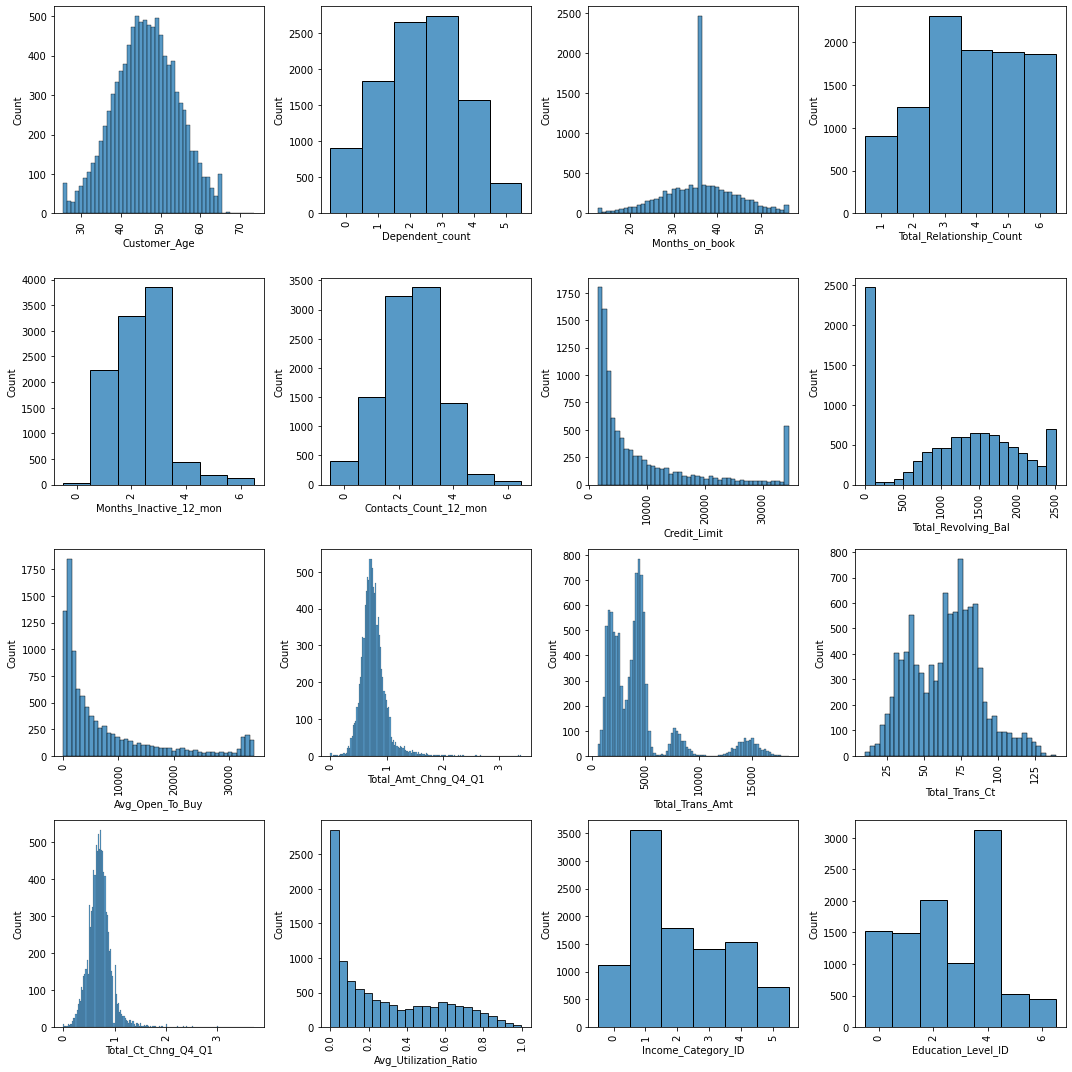

In [16]:
i=1
plt.figure(figsize=(15,15))
for attr in data[numerical_attributes]:
    discrete = False
    bin_num = len(data[attr].unique())
    if bin_num <=100:
        discrete = True
    bins = 'auto'
    plt.subplot(4,4,i)
    sns.histplot(data[attr], bins=bins, discrete=discrete)
    plt.tight_layout()
    plt.xticks(rotation=90)
    i+=1

In [17]:
print(data['Total_Revolving_Bal'].value_counts()[0])
print(data['Avg_Utilization_Ratio'].value_counts()[0])

2470
2470


### First Insights

- Customer_Age: Overall normal distribution, with a very light spike for younger and older customers.
- Dependent: Normal distribution
- Months_on_book: An, in comparison, very high number of customers have been on the books for 36 months. Shows an overall normal distribution, with the highest counts of customers being found for month values in the middle of the overall scale.
- Credit_Limit: The distribution of customers over credit limits is showing a strong decline, with most customers having lower end limits below 10,000. Only about 500 customers have a credit limit of 30,000 and higher. Ignoring these 500 customers, the plot shows a strong right-skewed distribution.
 - Total_Revolving_Bal: Most customers (2470) have no total revolving balance and around 750 customers fall into the maximum bracket of ca. 2500 balance. When ignoring these two distributions, the remaining total revolving balance counts show a normal distribution 
 - Avg_Open_To_Buy: Right-skewed distribution with a few outliers in the upper bound region
 - Total_Amt_Chng_Q4_Q1: Right-skewed distribution
 - Total_Trans_Amt: Right-skewed distribution, with two pronounced modes in the lower transaction amount area and two additional small modes. customers can be grouped into 3-4 customer groups based on their total transaction amounts.
 - Total_Trans_Ct: Non-symmetric bimodel distribution 
 - Avg_Utilization_Ratio: Right-skewed distribution with 2470 customers having an average utilization ratio of 0.
 - Income_Category_ID: Right-skewed distribution with most customers belong to income category 2 (Less than 40K Dollars)
 - Education_Level_ID: Right-skewed distribution with a mode at education level 4 (Graduate).
 
#### The hist plots for Total_Trans_Amt and Income_Category_ID show similar distributions


## Correlations and associations

### Spearman Correlation between continuous attributes

Since we're not exclusively looking for linearity in relationships between attributes, we're using the Spearman correlation for ranked correlation.
Correlation does not show effect/ causation.

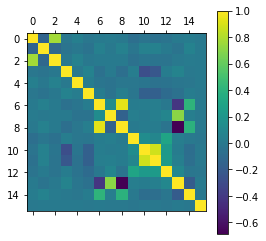

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Income_Category_ID,Education_Level_ID
Customer_Age,1.00,-0.14,0.77,-0.01,0.04,-0.01,0.00,0.01,-0.00,-0.07,-0.04,-0.05,-0.04,0.01,0.02,-0.00
Dependent_count,-0.14,1.00,-0.11,-0.04,-0.01,-0.04,0.05,-0.00,0.05,-0.03,0.06,0.05,0.01,-0.03,0.06,0.00
Months_on_book,0.77,-0.11,1.00,-0.01,0.06,-0.01,0.01,0.01,0.01,-0.05,-0.03,-0.04,-0.03,-0.00,0.02,0.00
Total_Relationship_Count,-0.01,-0.04,-0.01,1.00,-0.01,0.06,-0.06,0.01,-0.07,0.03,-0.28,-0.23,0.02,0.07,-0.00,0.00
Months_Inactive_12_mon,0.04,-0.01,0.06,-0.01,1.00,0.03,-0.03,-0.04,-0.02,-0.02,-0.03,-0.05,-0.05,-0.03,-0.02,0.01
Contacts_Count_12_mon,-0.01,-0.04,-0.01,0.06,0.03,1.00,0.02,-0.04,0.03,-0.02,-0.17,-0.17,-0.09,-0.06,0.02,-0.01
Credit_Limit,0.00,0.05,0.01,-0.06,-0.03,0.02,1.00,0.13,0.93,0.02,0.03,0.03,-0.01,-0.42,0.41,-0.00
Total_Revolving_Bal,0.01,-0.00,0.01,0.01,-0.04,-0.04,0.13,1.00,-0.15,0.04,0.02,0.04,0.08,0.71,0.03,-0.01
Avg_Open_To_Buy,-0.00,0.05,0.01,-0.07,-0.02,0.03,0.93,-0.15,1.00,0.01,0.02,0.02,-0.04,-0.69,0.40,-0.00
Total_Amt_Chng_Q4_Q1,-0.07,-0.03,-0.05,0.03,-0.02,-0.02,0.02,0.04,0.01,1.00,0.13,0.09,0.30,0.03,-0.00,-0.01


In [18]:
plt.matshow(data[numerical_attributes].corr(method='spearman'))
plt.colorbar()
plt.show()

np.set_printoptions(precision=1)
corrs = data[numerical_attributes].corr(method="spearman").round(2)
corrs

Correlations:

Very strong, positive correlation between average open to buy ratio per customer and their credit limit (Avg_Open_To_Buy - CreditLimit --> 0.93)

Strong, positive correlation between the total transaction amount per customer and the total transaction count. Customers with higher numbers of transactions also tend to have higher total transaction amounts (Total_Trans_Amt - Total_Trans_Ct --> 0.88)

Strong, positive correlation between customer age and the number of months they are registered. Older customers are also longer on the books at the company (Months_on_book - Customer_Age --> 0.77)

Strong, positive correlation between customers' average utilization ratio and their total revolving balance (Avg_Utilization_Ratio - Total_Revolving_Bal --> 0.71)

Moderate, negative correlation between customers' average utilization ratio and their average open to buy ratio. Customers with higher utilization ratio tend to have a lower open to buy ratio (Avg_Utilization_Ratio - Avg_Open_To_Buy --> -0.69)

Low, negative correlation between customers' average utilization ratio and their credit limit (Avg_Utilization_Ratio - Credit_Limit --> -0.42)

Low, positive correlation between customers' income category and their credit limits. Higher income category tend to also have a higher credit limit (Income_Category_ID - Credit_Limit --> 0.41)


### Cramer's V - Associations between categorical attributes

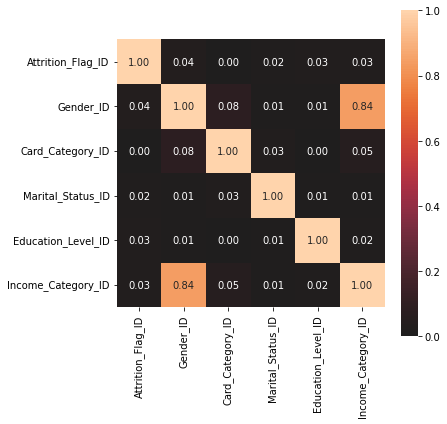

In [19]:
for el in categ_attributes:
    data[el] = data[el].astype("category")

complete_correlation= associations(data[categ_attributes], figsize=(6,6), cmap=None)

The only association between two categorical attributes is shown between the Gender and Income Category.

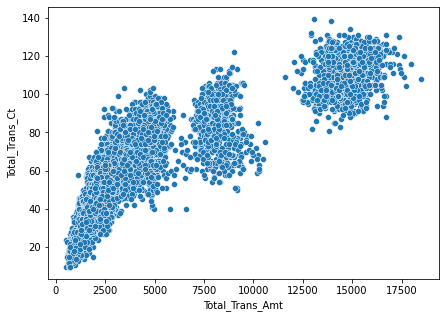

In [20]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=data, x='Total_Trans_Amt', y='Total_Trans_Ct')
plt.show()

Spearman correlation: Total_Trans_Amt - Total_Trans_Ct --> 0.88
The scatter plot shows confirms the existence of a positive correlation between the total transaction amount and total transaction count per customer. Customers can be split into three different customer groups based on their total transaction count and amount.

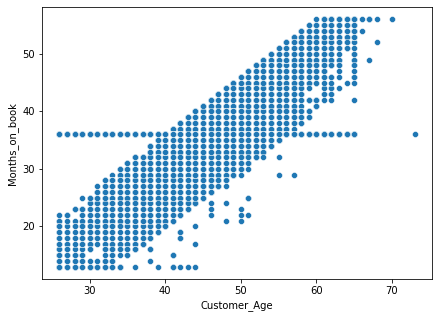

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=data, x='Customer_Age', y='Months_on_book')
plt.show()

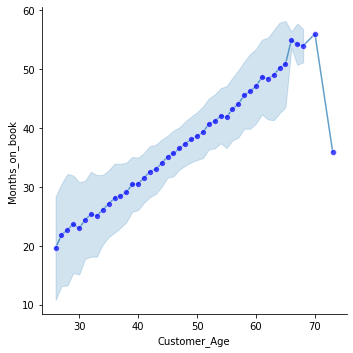

In [22]:
sns.relplot(
    x='Customer_Age',
    y='Months_on_book',
    kind='line',
    data=data,
    marker='o',
    alpha=0.7,
    markerfacecolor='blue',
    errorbar='sd'
)

plt.ylabel("Months_on_book")
plt.xlabel("Customer_Age")
plt.show()

Spearman correlation: Months_on_book - Customer_Age --> 0.77  The scatter plot as well as the relational plot show the positive correlation between customer age and customer months on books.

It is conspicuous that while most datapoints stay within a certain range of the mean values, there is an out of order vertical line of datapoints at months on book=36 for almost all ages.
#### According to the dataset there are also no older customers that have recently joined the company.

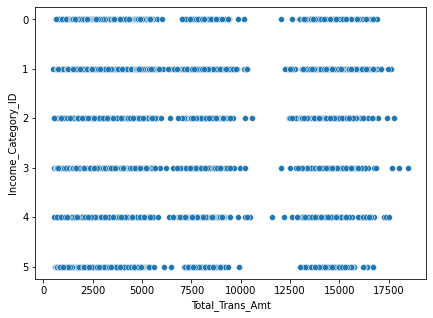

In [23]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=data, x='Total_Trans_Amt', y='Income_Category_ID')
plt.show()

Plotting the relationship between the total transaction amount per customer and their income category, we can see that there is a gap at ca. 11,000 Dollars total transaction amount, dividing customers over all six income categories.Interestingly, the middle income catgeory has the highest total transaction amount datapoints and not the highest income category.

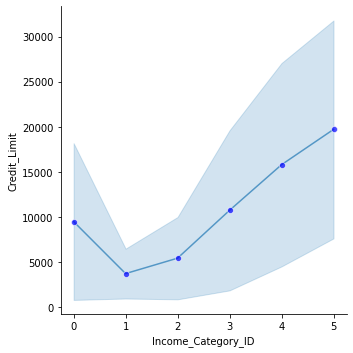

In [24]:
sns.relplot(
    x='Income_Category_ID',
    y='Credit_Limit',
    kind='line',
    data=data,
    marker='o',
    alpha=0.7,
    markerfacecolor='blue',
    errorbar='sd'
)

plt.ylabel("Credit_Limit")
plt.xlabel("Income_Category_ID")
plt.show()

Spearman correlation: Income_Category_ID - Credit_Limit --> 0.41

Excluding income category 0 (unknown income), we can see that with increasing income, the mean credit limit of customers is also increasing. The standard deviation of credit limit values is also increasing with increasing income category.

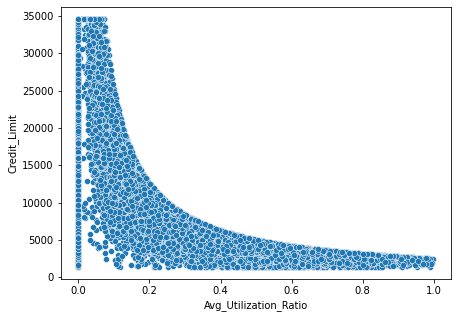

In [25]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=data, x='Avg_Utilization_Ratio', y='Credit_Limit')
plt.show()

Spearman correlation: Avg_Utilization_Ratio - Credit_Limit --> -0.42

The first string feature of the scatter plot is the very clear downwards slope, upper boundary. While there are customers with 0.0 average utilisation ratio spread over all credit limit values, customers with ratios > 0.0 have an increasingly lower credit limit. Customers having a credit limit over 15,000, all have an average utilisation ratio < 0.2, while customers with an average utilisation ratio of > 0.8 all have a credit limit of < 5,000.

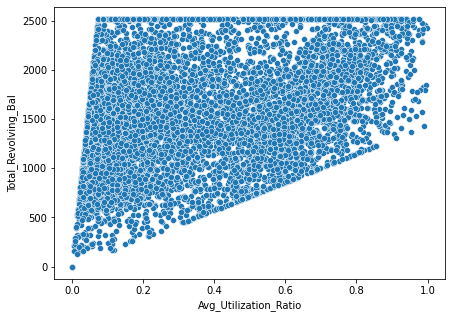

In [26]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=data, x='Avg_Utilization_Ratio', y='Total_Revolving_Bal')
plt.show()

Spearman correlation: Avg_Utilization_Ratio - Total_Revolving_Bal --> 0.71

Again, we can see very clear, distinct boundaries of the data in the scatter plot. The higher the total revolving balance, the higher the average utilisation ratio and the higher the spread of datapoints. 

### Add additional age binning column for data evaluation

In [27]:
bins = [20, 30, 40, 50, 60, 70, 80]
data['Customer_Age_Binned'] = pd.cut(data['Customer_Age'], bins)
data.head(2)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag_ID,Gender_ID,Card_Category_ID,Marital_Status_ID,Education_Level_ID,Income_Category_ID,Customer_Age_Scaled,Dependent_count_Scaled,Months_on_book_Scaled,Total_Relationship_Count_Scaled,Months_Inactive_12_mon_Scaled,Contacts_Count_12_mon_Scaled,Credit_Limit_Scaled,Total_Revolving_Bal_Scaled,Avg_Open_To_Buy_Scaled,Total_Amt_Chng_Q4_Q1_Scaled,Total_Trans_Amt_Scaled,Total_Trans_Ct_Scaled,Total_Ct_Chng_Q4_Q1_Scaled,Avg_Utilization_Ratio_Scaled,Attrition_Flag_ID_Scaled,Gender_ID_Scaled,Card_Category_ID_Scaled,Marital_Status_ID_Scaled,Education_Level_ID_Scaled,Income_Category_ID_Scaled,Customer_Age_Binned
CLIENTNUM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1,1,0,1,2,3,-0.165406,0.503368,0.384621,0.763943,-1.327136,0.492404,0.446622,-0.473422,0.488971,2.623494,-0.959707,-0.973895,3.834003,-0.775882,0.437506,1.059956,-0.259473,-0.628128,-0.354022,0.620039,"(40, 50]"
818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1,0,0,2,4,1,0.333570,2.043199,1.010715,1.407306,-1.327136,-0.411616,-0.041367,-0.366667,-0.008486,3.563293,-0.916433,-1.357340,12.608573,-0.616276,0.437506,-0.943436,-0.259473,0.727306,0.822218,-0.736292,"(40, 50]"


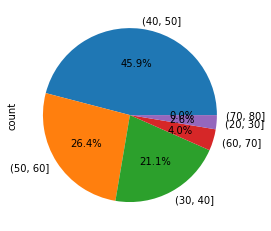

In [28]:
fig, ax = plt.subplots(figsize=(4, 4))
data['Customer_Age_Binned'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

45% of customers belong to the age group 40-50, with the second biggest group being the 50-60 years olds. 

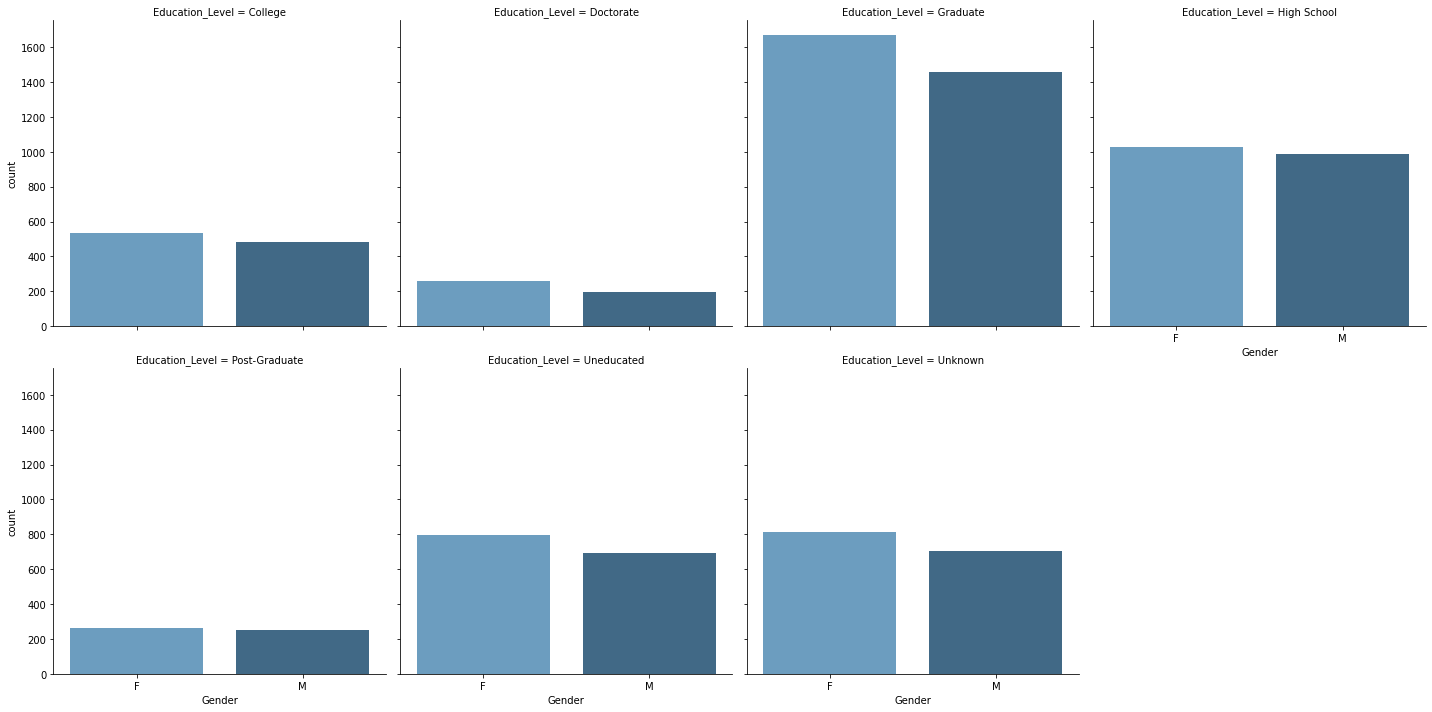

In [29]:
sns.catplot(data=data, x='Gender', palette='Blues_d', kind='count', col='Education_Level', hue='Gender', col_wrap=4)
plt.show()

Data grouped by education level and by gender. There are more female customers, than male ones on each education level. Most customers belong to the education level 'graduate'. The least customers have a 'doctorate' level.

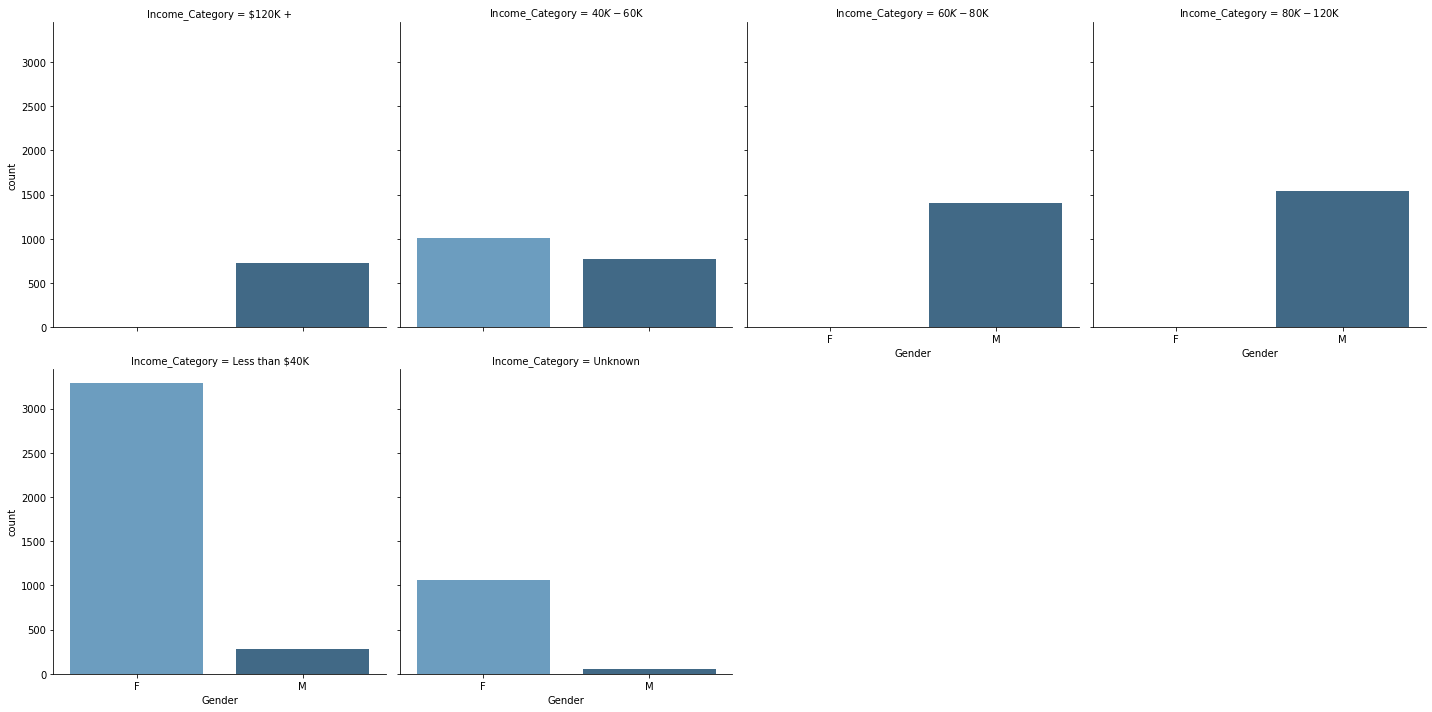

In [30]:
sns.catplot(data=data, x='Gender', palette='Blues_d', kind='count', col='Income_Category', hue='Gender', col_wrap=4)
plt.show()

Data grouped by income category and gender. The three highest income category (120K+ , 80K-120K, 60K-80K) consist of exclusively male customers. In the unknown and lowest income (< 40K) categories female customers are overrepresented in comparison to male customers. In the income category 40K-60K there are slightly more female customers than male ones.

Question for further evaluation: Since all female customers belong to lower income categories, do they also show differences in other financial attributes like credit limit or transaction count?

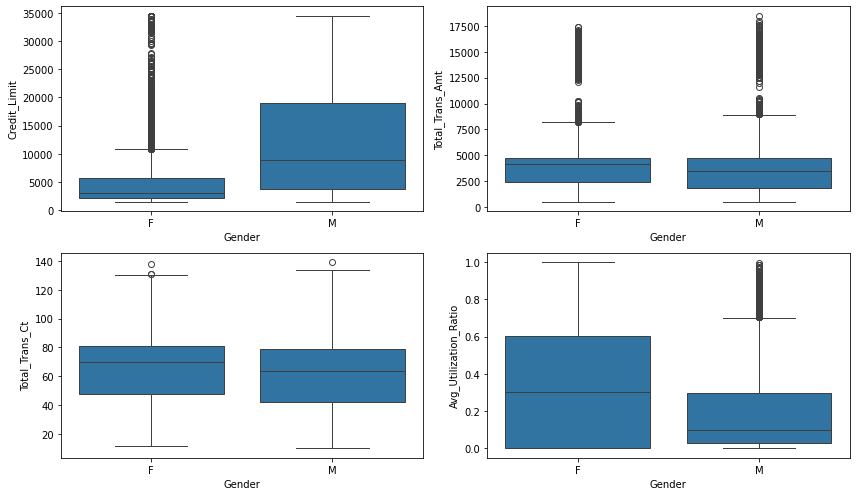

In [31]:
fig, ax = plt.subplots(2,2,figsize=(12, 7))
sns.boxplot(data=data, x="Gender", y="Credit_Limit", ax=ax[0][0])
sns.boxplot(data=data, x="Gender", y="Total_Trans_Amt", ax=ax[0][1])
sns.boxplot(data=data, x="Gender", y="Total_Trans_Ct", ax=ax[1][0])
sns.boxplot(data=data, x="Gender", y="Avg_Utilization_Ratio", ax=ax[1][1])
plt.tight_layout()
plt.show()

Female customers also have overall lower credit limits than male customers. The mean credit limit value for female customers is lower than the lower quartile for the male customers.

Interestingly, the mean values for the total transaction amount, total transaction count and average utilisation ratio are higher for female customers.

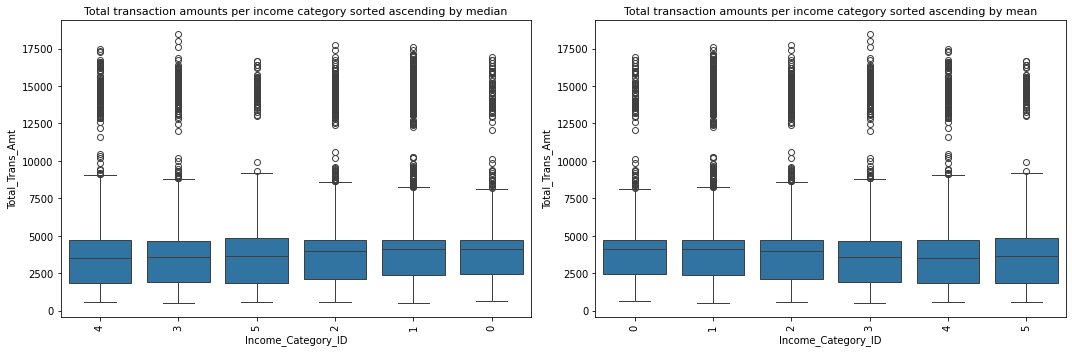

,count,mean,std,min,25%,50%,75%,max
Income_Category_ID,,,,,,,,
0,1112.0,4282.211331,2922.695013,644.0,2452.75,4107.0,4725.00,16908.0
1,3561.0,4363.420107,3097.398449,510.0,2398.00,4099.0,4751.00,17628.0
2,1790.0,4405.618994,3382.499980,569.0,2141.00,3967.0,4741.75,17744.0
3,1402.0,4450.712553,3789.005119,530.0,1903.25,3552.5,4672.25,18484.0
4,1535.0,4482.960261,3788.213644,563.0,1836.50,3525.0,4741.50,17498.0
5,727.0,4529.467675,3816.054540,602.0,1870.50,3643.0,4831.50,16695.0


In [32]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))

grouped_median = data.loc[:,['Income_Category_ID', 'Total_Trans_Amt']] \
    .groupby(['Income_Category_ID']) \
    .median() \
    .sort_values(by='Total_Trans_Amt')

sns.boxplot(x=data['Income_Category_ID'], y=data['Total_Trans_Amt'], order=grouped_median.index, showfliers=True, ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels())
axes[0].tick_params(axis='x', labelrotation = 90)
axes[0].set_xlabel('Income_Category_ID')
axes[0].set_title('Total transaction amounts per income category sorted ascending by median', fontsize=11)


grouped_mean = data.loc[:,['Income_Category_ID', 'Total_Trans_Amt']] \
    .groupby(['Income_Category_ID']) \
    .mean() \
    .sort_values(by='Total_Trans_Amt')

sns.boxplot(x=data['Income_Category_ID'], y=data['Total_Trans_Amt'], order=grouped_mean.index, showfliers=True, ax = axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels())
axes[1].tick_params(axis='x', labelrotation = 90)
axes[1].set_title('Total transaction amounts per income category sorted ascending by mean', fontsize=11)

plt.tight_layout()
plt.show()

data.groupby('Income_Category_ID')['Total_Trans_Amt'].describe()

#### Total transaction amounts of customers grouped by their income catgeory
- most customers belong to income category 1 (Less than 40K Dollars), least belong to income category 5 (120K Dollars +)
- Looking at the mean values, the higher the income category, the higher the mean total transaction amount.
- Looking at the median values, we can see an almost completely reverse order where lower income categories have higher median total transaction amounts

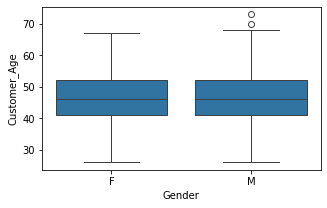

In [33]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=data, x="Gender", y="Customer_Age")
plt.show()

The age distribution between customer genders is very comparable, with the median age being ca. 46 years for both genders and the quartile being seemingly equal.

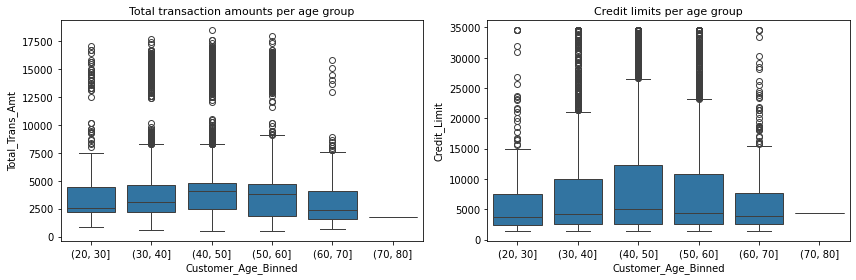

In [35]:
fig, ax = plt.subplots(1,2,figsize=(12, 4))
sns.boxplot(data=data, x="Customer_Age_Binned", y="Total_Trans_Amt", ax=ax[0])
ax[0].set_title('Total transaction amounts per age group', fontsize=11)
sns.boxplot(data=data, x="Customer_Age_Binned", y="Credit_Limit", ax=ax[1])
ax[1].set_title('Credit limits per age group', fontsize=11)
plt.tight_layout()
plt.show()

Middle age groups have the highest median transaction amount. The highest median amount belongs to age group 40-50, with increasing and decreasing age respectively, the median transaction amount keeps decreasing.

We can see similar behaviour for the credit limits per age group.

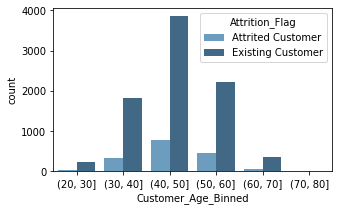

In [36]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.countplot(data=data, x='Customer_Age_Binned', palette='Blues_d', hue='Attrition_Flag')
plt.show()

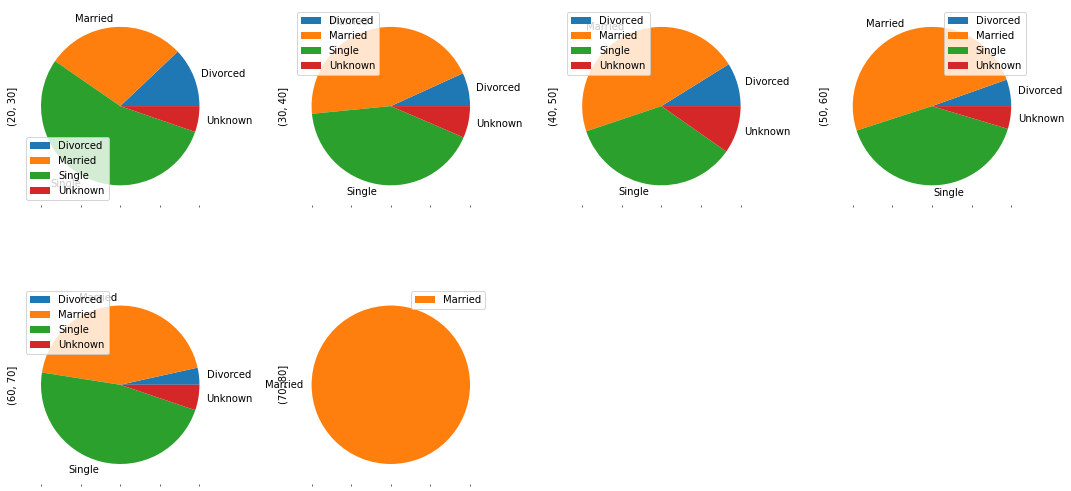

In [37]:
group = data.groupby(['Marital_Status', 'Customer_Age_Binned']).size().unstack(fill_value=0)
group.plot.pie(subplots=True, layout=(2,4), figsize=(15, 8), legend=True)
plt.tight_layout()
plt.show()

Data grouped by age groups:
- While in the youngest age group (20-30) most customers are single, the share of married customers increases to ca. 50% until age group 50-60. In the age group 60-70 the share of married and single customers are of equal size. In the oldest age group (70-80) 100% of all customers are married.

- The youngest age group (20-30) has the higehst share of divorced customers

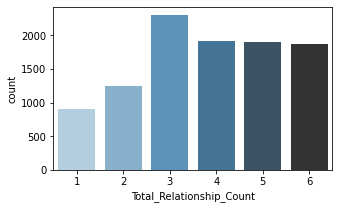

In [38]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.countplot(data=data, x='Total_Relationship_Count', palette='Blues_d', hue='Total_Relationship_Count', legend=False)
plt.show()

Most customers have three relationships with the credit card provider, while least customers have only one.

## Definition of functions for predictions tasks

In [39]:
def prepare_data(predicted_attr='Income_Category_ID', remove_data=[], test_size=0.3):
    y = data[predicted_attr].to_numpy()
    used_features = scaled_features.copy()
    used_features.remove(f'{predicted_attr}_Scaled')
    for el in remove_data:
        try:
            used_features.remove(f'{el}_Scaled')
            print(f'Successfully removed {el}')
        except:
            print("could not be removed. Check spelling.")
    x = data[used_features]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=0)
    
    input_dim = len(used_features)
    
    return x_train, x_test, y_train, y_test, input_dim

In [40]:
def run_Gaussian_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False):
    model = GaussianNB()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = round(accuracy_score(y_test, y_pred), 4)
    metrics = f'Gaussian NB Classifier Acc = {acc}'
    random_preds = np.take(y_pred, indices)
    if line_plot:
        plot_pred_accuracy(random_preds, random_trues, metrics, pred_attribute)
    plot_confusion_matrix(y_test, y_pred, metrics, pred_attribute)


def run_KNN_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False):
    model = KNeighborsClassifier()#n_neighbors=6)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = round(accuracy_score(y_test, y_pred), 4)
    metrics = f'KNN Classifier Acc = {acc}'
    random_preds = np.take(y_pred, indices)
    if line_plot:
        plot_pred_accuracy(random_preds, random_trues, metrics, pred_attribute)
    plot_confusion_matrix(y_test, y_pred, metrics, pred_attribute)


def run_Ridge_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False):
    model = RidgeClassifier(random_state = 0)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = round(accuracy_score(y_test, y_pred), 4)
    metrics = f'Ridge Classifier Acc = {acc}'
    random_preds = np.take(y_pred, indices)
    if line_plot:
        plot_pred_accuracy(random_preds, random_trues, metrics, pred_attribute)
    plot_confusion_matrix(y_test, y_pred, metrics, pred_attribute)
    
def run_RandForest_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False):
    model = RandomForestClassifier(random_state = 0)#,max_depth=2)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = round(accuracy_score(y_test, y_pred), 4)
    metrics = f'Random Forest Classifier Acc = {acc}'
    random_preds = np.take(y_pred, indices)
    if line_plot:
        plot_pred_accuracy(random_preds, random_trues, metrics, pred_attribute)
    plot_confusion_matrix(y_test, y_pred, metrics, pred_attribute)


def run_MLP_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False, num_epochs=20):
    model = MLPClassifier(random_state=0, max_iter=num_epochs)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    acc = round(accuracy_score(y_test, y_pred), 4)
    metrics = f'MLP Classifier Acc = {acc}'
    random_preds = np.take(y_pred, indices)
    if line_plot:
        plot_pred_accuracy(random_preds, random_trues, metrics, pred_attribute)
    plot_confusion_matrix(y_test, y_pred, metrics, pred_attribute)
    

In [41]:
def run_linear_regression(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute):
    model = LinearRegression()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = round(mean_squared_error(y_test, y_pred, squared=False), 4)
    metrics = f'Linear Regression r2 = {r2}  rmse = {rmse}'
    #print(metrics)
    random_preds = np.take(y_pred, indices)
    plot_pred_accuracy(random_preds, random_trues, metrics, pred_attribute)
    
def run_ridge_regression(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute):
    model = Ridge()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = round(mean_squared_error(y_test, y_pred, squared=False), 4)
    metrics = f'Ridge Regression r2 = {r2}  rmse = {rmse}'
    #print(metrics)
    random_preds = np.take(y_pred, indices)
    plot_pred_accuracy(random_preds, random_trues, metrics, pred_attribute)

def run_knn_regression(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute):
    model = KNeighborsRegressor()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = round(mean_squared_error(y_test, y_pred, squared=False), 4)
    metrics = f'KNN Regression r2 = {r2}  rmse = {rmse}'
    #print(metrics)
    random_preds = np.take(y_pred, indices)
    plot_pred_accuracy(random_preds, random_trues, metrics, pred_attribute)
    
def run_random_forest_regression(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute):
    model = RandomForestRegressor()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = round(mean_squared_error(y_test, y_pred, squared=False), 4)
    metrics = f'Random Forest Regression r2 = {r2}  rmse = {rmse}'
    #print(metrics)
    random_preds = np.take(y_pred, indices)
    plot_pred_accuracy(random_preds, random_trues, metrics, pred_attribute)


In [42]:
def plot_confusion_matrix(y_test, y_pred, title, pred_attribute):
    fig, ax = plt.subplots(figsize=(3,3))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, ax=ax)
    plt.title(f'{pred_attribute}: {title}', fontsize=10)
    plt.tight_layout()
    plt.show()
    


In [43]:
def plot_pred_accuracy(random_preds, random_trues, title="", ylabel=""):
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(range(len(random_trues)), random_trues, color='blue', label="true")
    ax.plot(range(len(random_preds)), random_preds, color='red', label="pred")
    plt.xlabel('random test elements')
    plt.ylabel(ylabel)
    plt.xticks([])
    plt.title(f'{ylabel}: {title}', fontsize=11)
    plt.legend()
    plt.show()

In [44]:
class CreditDataset(Dataset):
    def __init__(self, features, prices):
        super(CreditDataset, self).__init__()
        self.features = torch.from_numpy(np.array(features)).type(torch.float32)
        self.prices = torch.from_numpy(np.array(prices)).type(torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.prices[idx]

In [45]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.act = nn.ReLU()
        self.output = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x
    


## Binary Classification
#### Predictable binary attributes zu choose from:
Gender_ID, Attrition_Flag_ID (while gender labels are pretty balanced in the underlying dataset, attrition flag labels are imbalanced)

In [46]:
pred_attribute = 'Gender_ID'

x_train, x_test, y_train, y_test, input_dim = prepare_data(predicted_attr=pred_attribute, test_size=0.3, remove_data=[])

# indices for displaying prediction accuracy plots
indices = random.sample(range(len(y_test)), 100)
random_trues =  np.take(list(y_test), indices)

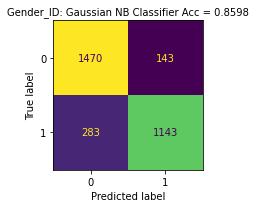

In [47]:
run_Gaussian_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False)

- Gender classification: Gaussian Naive Bayes Classifier can predict the gender label correctly with an accuracy of ca. 85%
- Attrition classification: Gaussian Naive Bayes Classifier can predict the attrition label correctly with an accuracy of ca. 88%

C:\Users\Nadine\.conda\envs\pytorch_project\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


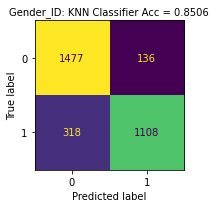

In [48]:
run_KNN_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False)

- Gender classification: K-Nearest Neighbour Classifier can predict the gender label correctly with an accuracy of ca. 85%
- Attrition classification: K-Nearest Neighbour Classifier can predict the attrition label correctly with an accuracy of ca. 90%

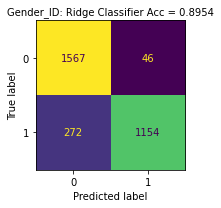

In [49]:
run_Ridge_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False)

- Gender classification: Ridge Classifier can predict the gender label correctly with an accuracy of ca. 89%
- Attrition classification: Ridge Classifier can predict the attrition label correctly with an accuracy of ca. 90%

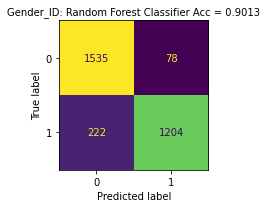

In [50]:
run_RandForest_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False)

- Gender classification: Random Forest Classifier can predict the gender label correctly with an accuracy of ca. 90%
- Attrition classification: Random Forest Classifier can predict the attrition label correctly with an accuracy of ca. 96%

C:\Users\Nadine\.conda\envs\pytorch_project\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


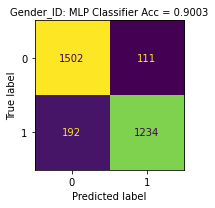

In [51]:
run_MLP_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False, num_epochs=20)

- Gender classification: Multi-layer Perceptron Classifier can predict the gender label correctly with an accuracy of ca. 90%
- Attrition classification: Multi-layer Perceptron Classifier can predict the attrition label correctly with an accuracy of ca. 92%

### Testing a self-written binary classifier

Model Training: 100%|██████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.06it/s]

Best Epoch 49 	 Accuracy=0.9035867061533399


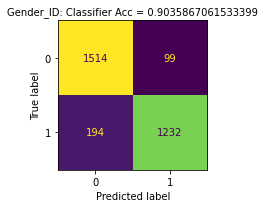

In [52]:
batch_size = 128
lr = 0.001
hidden_dim = 12
output_dim = 1

traindata = CreditDataset(x_train, y_train)
trainloader = DataLoader(traindata, batch_size=batch_size, 
                         shuffle=True, num_workers=0)

testdata = CreditDataset(x_test, y_test)
testloader = DataLoader(testdata, batch_size=128, 
                         shuffle=False, num_workers=0)



model = BinaryClassifier(input_dim, hidden_dim, output_dim)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_epoch = 0
best_acc = 0
best_preds = []

for epoch in tqdm(range(50), desc= f'Model Training'):#tqdm(range(100), desc= f'Epoch {epoch}'):
    model.train()
    preds = []
    trues = []
    losses = 0
    for el in trainloader:
        x_batch, y_batch = el
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        for el in testloader:
            x_batch, y_batch = el
            y_pred = model(x_batch)
            probs = torch.sigmoid(y_pred)
            ce = loss_fn(y_pred, y_batch)
            losses += ce.item()
            trues.extend(y_batch)
            preds.extend(probs)
    
    preds = torch.cat(preds)
    preds = torch.round(preds)
    trues = torch.cat(trues)
    acc = accuracy_score(trues, preds)
    if acc > best_acc:
        best_acc = acc
        best_epoch = epoch
        best_preds = preds

print(f"Best Epoch {best_epoch} \t Accuracy={best_acc}")
plot_confusion_matrix(y_test, best_preds, f'Classifier Acc = {best_acc}', pred_attribute)
    

- Gender classification: The self-written Classifier can predict the gender label correctly with an accuracy of ca. 90%
- Attrition classification: The self-written Classifier can predict the attrition label correctly with an accuracy of ca. 92%

## Non-binary Classification

#### Predictable attributes zu choose from:
Card_Category_ID, Marital_Status_ID, Education_Level_ID, Income_Category_ID

In [53]:
pred_attribute = 'Income_Category_ID'

x_train, x_test, y_train, y_test, input_dim = prepare_data(predicted_attr=pred_attribute, test_size=0.3)

# indices for displaying prediction accuracy plots
indices = random.sample(range(len(y_test)), 100)
random_trues =  np.take(list(y_test), indices)

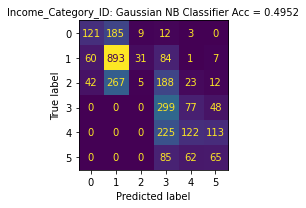

In [54]:
run_Gaussian_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False)

- Income category classification: Gaussian Naive Bayes Classifier can predict the income category label correctly with an accuracy of ca. 49%

C:\Users\Nadine\.conda\envs\pytorch_project\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


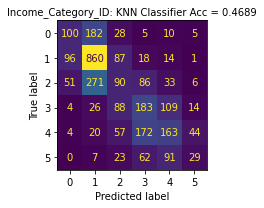

In [55]:
run_KNN_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False)

- Income category classification: K-Nearest Neighbour Classifier can predict the income category label correctly with an accuracy of ca. 46%

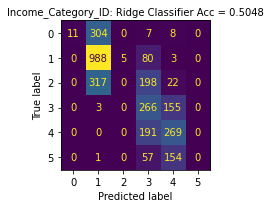

In [56]:
run_Ridge_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False)

- Income category classification: Ridge Classifier can predict the income category label correctly with an accuracy of ca. 50%

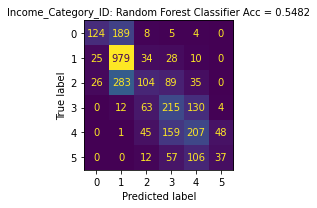

In [57]:
run_RandForest_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False)

- Income category classification: Random Forest Classifier can predict the income category label correctly with an accuracy of ca. 54%

C:\Users\Nadine\.conda\envs\pytorch_project\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


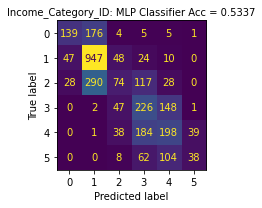

In [58]:
run_MLP_Classifier(x_train, x_test, y_train, y_test, indices, random_trues, pred_attribute, line_plot=False, num_epochs=20)

- Income category classification: Multi-Level Perceptron Classifier can predict the income category label correctly with an accuracy of ca. 53%

## Regression Predictions
#### Predictable attributes zu choose from:
Customer_Age, Dependent_count, Months_on_book, Total_Relationship_Count, Months_Inactive_12_mon,
Contacts_Count_12_mon, Credit_Limit, Total_Revolving_Bal, Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1,
Total_Trans_Amt, Total_Trans_Ct, Total_Ct_Chng_Q4_Q1, Avg_Utilization_Ratio


#### Notes:
Removing attributes with very high correlations might be necessary. 
- 'Credit_Limit' has a very strong correlation with 'Avg_Open_To_Buy'. When trying to predict the 'Credit_Limit', not removing the latter attribute data has a strong positive influence on the prediction accuracy.
- 'Total_Trans_Amt' has a strong correlation with 'Total_Trans_Ct'

In [59]:
predicted_attr = 'Credit_Limit'
x_train, x_test, y_train, y_test, input_dim = prepare_data(predicted_attr=predicted_attr, test_size=0.3, remove_data=['Avg_Open_To_Buy'])

#predicted_attr = 'Customer_Age'
#x_train, x_test, y_train, y_test, input_dim = prepare_data(predicted_attr=predicted_attr, test_size=0.3, remove_data=[''])


# indices for displaying prediction accuracy plots
indices = random.sample(range(len(y_test)), 100)
random_trues =  np.take(list(y_test), indices)


Successfully removed Avg_Open_To_Buy


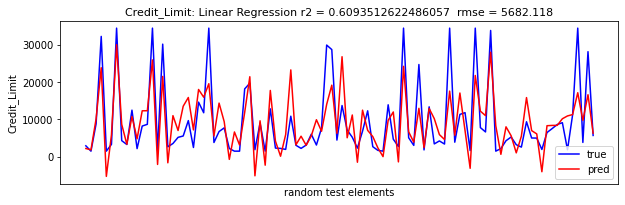

In [60]:
run_linear_regression(x_train, x_test, y_train, y_test, indices, random_trues, predicted_attr)

- Credit limit regression prediction: Linear regressor can predict the credit limit value correctly with an RMSE of ca. 5,682.

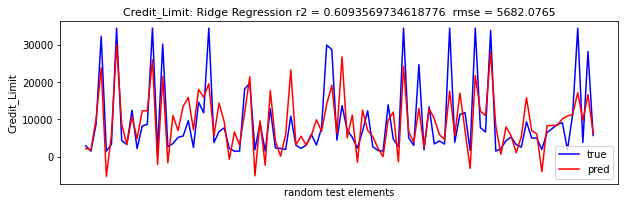

In [61]:
run_ridge_regression(x_train, x_test, y_train, y_test, indices, random_trues, predicted_attr)

- Credit limit regression prediction: Ridge regressor can predict the credit limit value correctly with an RMSE of ca. 5,682.

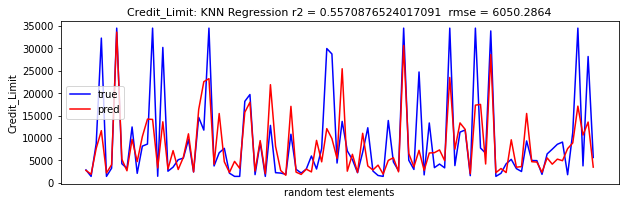

In [62]:
run_knn_regression(x_train, x_test, y_train, y_test, indices, random_trues, predicted_attr)

- Credit limit regression prediction: K-Nearest Neighbour regressor can predict the credit limit value correctly with an RMSE of ca. 6,050.

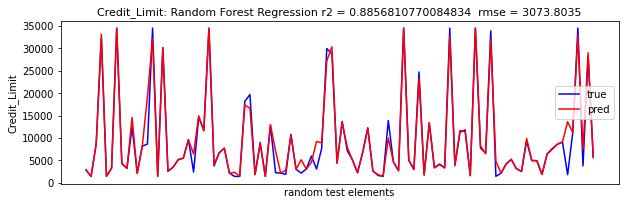

In [63]:
run_random_forest_regression(x_train, x_test, y_train, y_test, indices, random_trues, predicted_attr)

- Credit limit regression prediction: Random Forest regressor can predict the credit limit value correctly with an RMSE of ca. 3090.

### Testing a self-written regression model

In [74]:
n_epochs = 250
batch_size = 32
lr = 0.01
first_dim = 12
second_dim = 8
third_dim = 4


traindata = CreditDataset(x_train, y_train)
trainloader = DataLoader(traindata, batch_size=batch_size, 
                         shuffle=True, num_workers=0)

testdata = CreditDataset(x_test, y_test)
testloader = DataLoader(testdata, batch_size=128, 
                         shuffle=False, num_workers=0)


model = nn.Sequential(
    nn.Linear(input_dim, first_dim),
    nn.ReLU(),
    nn.Linear(first_dim, second_dim),
    nn.ReLU(),
    nn.Linear(second_dim, 1),
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:10<00:00,  3.55it/s]

best rmse: 3648.763916015625 in Epoch 242


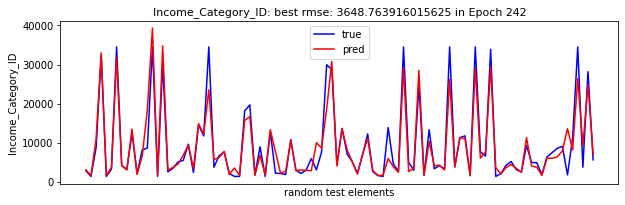

In [77]:
best_rmse = 10000000
best_epoch = 0
best_preds = []

for epoch in tqdm(range(n_epochs)):
    trues = []
    preds = []
    model.train()
    for data in trainloader:
        x_batch, y_batch = data
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        for data in testloader:
            x_batch, y_batch = data
            y_pred = model(x_batch)
            mse_loss = loss_fn(y_pred, y_batch)
            trues.extend(y_batch)
            preds.extend(y_pred)
    
    preds = torch.cat(preds)
    trues = torch.cat(trues)
    r2 = r2_score(preds, trues)
    rmse = round(mean_squared_error(trues, preds, squared=False), 4)
    
    if rmse < best_rmse:
        best_rmse = rmse.copy()
        best_epoch = epoch
        best_preds = preds.detach().clone()
    
title = f"best rmse: {best_rmse} in Epoch {best_epoch}" 
print(title)

random_trues = trues[indices]
random_preds = best_preds[indices]

plot_pred_accuracy(random_preds, random_trues, title=title, ylabel=pred_attribute)


- Credit limit regression prediction: Self-written regressor can predict the credit limit value correctly with an RMSE of ca. 3648.